In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words/641.png
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words/173.png
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words/491.png
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words/718.png
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words/709.png
/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words/379.png
/kaggle/input/doctors-handwrit

In [5]:
import os
from glob import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [6]:
BASE_DIR = "/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset"
OUTPUT_BASE = "/kaggle/working/processed_dataset_v2"

SPLITS = {
    "Training":   "training_words",
    "Validation": "validation_words", 
    "Testing":    "testing_words"
}

OUTPUT_SUFFIX = "enhanced_gray_320"
TARGET_SIZE = 320
EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")


In [9]:
def enhance_image(gray):
    """Apply adaptive equalization, denoise, and sharpening."""
    # 1️ Adaptive histogram equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    # 2️⃣ Remove small noise
    enhanced = cv2.medianBlur(enhanced, 3)

    # 3️⃣ Sharpen text edges
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    enhanced = cv2.filter2D(enhanced, -1, kernel)
    return enhanced


In [10]:
def process_folder(input_folder: str, output_folder: str, target_size: int = 320, preview=False):
    os.makedirs(output_folder, exist_ok=True)

    image_files = []
    for ext in EXTS:
        image_files.extend(glob(os.path.join(input_folder, f"*{ext}")))

    print(f"\n Input : {input_folder}")
    print(f" Output: {output_folder}")
    print(f" Total images found: {len(image_files)}")

    if len(image_files) == 0:
        return

    sample_show = []

    for i, file in enumerate(image_files, start=1):
        img = cv2.imread(file)
        if img is None:
            print(f" Failed to read: {file}")
            continue

        # Step 1 — Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Step 2 — Enhance the image
        gray = enhance_image(gray)

        # Step 3 — Resize (keep aspect ratio)
        h, w = gray.shape
        scale = min(target_size / w, target_size / h)
        new_w, new_h = max(1, int(w * scale)), max(1, int(h * scale))
        resized = cv2.resize(gray, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Step 4 — Create centered canvas
        bg_color = int(np.median(resized))
        canvas = np.full((target_size, target_size), bg_color, dtype=np.uint8)
        x_offset = (target_size - new_w) // 2
        y_offset = (target_size - new_h) // 2
        canvas[y_offset:y_offset + new_h, x_offset:x_offset + new_w] = resized

        # Step 5 — Save image
        filename = os.path.basename(file)
        save_path = os.path.join(output_folder, filename)
        cv2.imwrite(save_path, canvas)

        # For preview
        if preview and i < 4:
            sample_show.append((gray, canvas))

        if i % 100 == 0 or i == len(image_files):
            print(f"[{i}/{len(image_files)}]  Processed")

    # Optional — visualize sample before/after
    if preview and len(sample_show) > 0:
        plt.figure(figsize=(10, 4))
        for idx, (g, c) in enumerate(sample_show):
            plt.subplot(2, len(sample_show), idx + 1)
            plt.imshow(g, cmap="gray"); plt.axis("off"); plt.title("Enhanced")
            plt.subplot(2, len(sample_show), idx + 1 + len(sample_show))
            plt.imshow(c, cmap="gray"); plt.axis("off"); plt.title("Resized")
        plt.suptitle(f"Sample preview: {os.path.basename(input_folder)}")
        plt.tight_layout()
        plt.show()


In [11]:
def main():
    for split_name, images_subdir in SPLITS.items():
        input_folder  = os.path.join(BASE_DIR, split_name, images_subdir)
        output_folder = os.path.join(OUTPUT_BASE, split_name, f"{images_subdir}_{OUTPUT_SUFFIX}_{TARGET_SIZE}")

        if not os.path.isdir(input_folder):
            print(f"⚠️ Skipping (folder missing): {input_folder}")
            continue

        process_folder(input_folder, output_folder, TARGET_SIZE, preview=True)



 Input : /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words
 Output: /kaggle/working/processed_dataset_v2/Training/training_words_enhanced_gray_320_320
 Total images found: 3120
[100/3120]  Processed
[200/3120]  Processed
[300/3120]  Processed
[400/3120]  Processed
[500/3120]  Processed
[600/3120]  Processed
[700/3120]  Processed
[800/3120]  Processed
[900/3120]  Processed
[1000/3120]  Processed
[1100/3120]  Processed
[1200/3120]  Processed
[1300/3120]  Processed
[1400/3120]  Processed
[1500/3120]  Processed
[1600/3120]  Processed
[1700/3120]  Processed
[1800/3120]  Processed
[1900/3120]  Processed
[2000/3120]  Processed
[2100/3120]  Processed
[2200/3120]  Processed
[2300/3120]  Processed
[2400/3120]  Processed
[2500/3120]  Processed
[2600/3120]  Processed
[2700/3120]  Processed
[2800/3120]  Processed
[2900/3120]  Processed
[3000/3120]  Processed
[3100/3120]  Processed
[3120/3120]  Processed


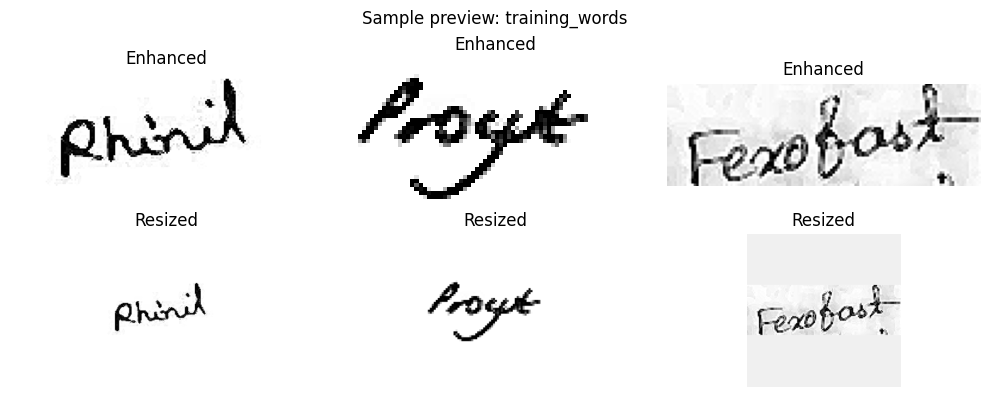


 Input : /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words
 Output: /kaggle/working/processed_dataset_v2/Validation/validation_words_enhanced_gray_320_320
 Total images found: 780
[100/780]  Processed
[200/780]  Processed
[300/780]  Processed
[400/780]  Processed
[500/780]  Processed
[600/780]  Processed
[700/780]  Processed
[780/780]  Processed


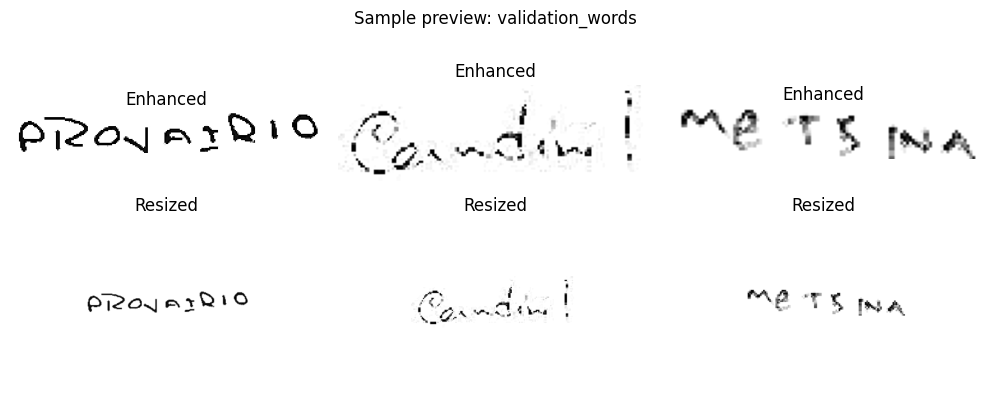


 Input : /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_words
 Output: /kaggle/working/processed_dataset_v2/Testing/testing_words_enhanced_gray_320_320
 Total images found: 780
[100/780]  Processed
[200/780]  Processed
[300/780]  Processed
[400/780]  Processed
[500/780]  Processed
[600/780]  Processed
[700/780]  Processed
[780/780]  Processed


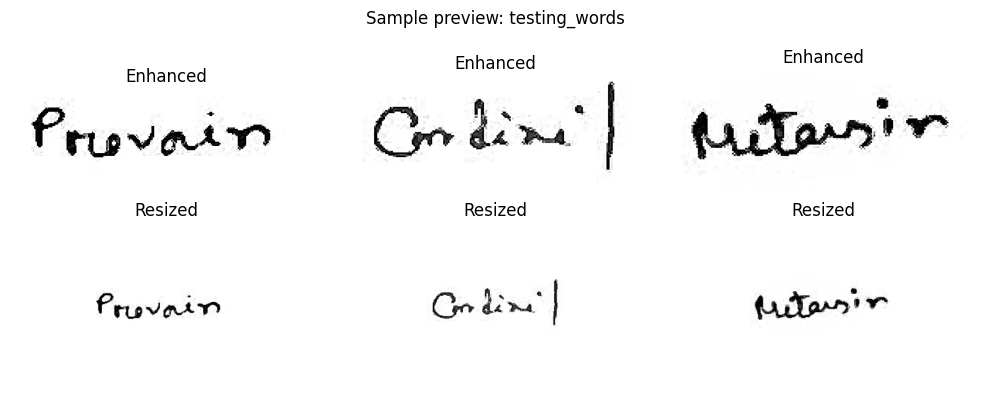

In [12]:
if __name__ == "__main__":
    main()


In [15]:
import os
import time
import json
import random
import numpy as np
import pandas as pd
from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models


SEED = 42

def set_seed(seed=SEED):
    """Ensure full reproducibility across libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MIXED_PRECISION = torch.cuda.is_available()   # use autocast if CUDA available

print(f" Device Detected: {DEVICE.upper()}")
if MIXED_PRECISION:
    print(" Mixed Precision Enabled (AMP)")

TARGET_SIZE   = (320, 320)     # image resize target
BATCH_SIZE    = 32
EPOCHS        = 25             # increased slightly for better convergence
LR            = 1e-3
WEIGHT_DECAY  = 1e-4
PATIENCE      = 5              # early stopping patience
NUM_WORKERS   = 2              # can raise if Kaggle GPU allows

timestamp = time.strftime("%Y%m%d_%H%M%S")
SAVE_DIR = f"./checkpoints_resnet18_{timestamp}"
os.makedirs(SAVE_DIR, exist_ok=True)

print(f" Checkpoints will be saved to: {SAVE_DIR}")

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

print(json.dumps({
    "seed": SEED,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "learning_rate": LR,
    "weight_decay": WEIGHT_DECAY,
    "target_size": TARGET_SIZE,
    "device": DEVICE
}, indent=2))


 Device Detected: CUDA
 Mixed Precision Enabled (AMP)
 Checkpoints will be saved to: ./checkpoints_resnet18_20251011_172223
{
  "seed": 42,
  "epochs": 25,
  "batch_size": 32,
  "learning_rate": 0.001,
  "weight_decay": 0.0001,
  "target_size": [
    320,
    320
  ],
  "device": "cuda"
}


In [16]:
import os

# Path to the preprocessed dataset (not the original one)
DATA_DIR = "/kaggle/working/processed_dataset"

# Define subdirectories for each split
TRAIN_IMG_DIR = os.path.join(DATA_DIR, "Training", "training_words_gray_320_320")
VAL_IMG_DIR   = os.path.join(DATA_DIR, "Validation", "validation_words_gray_320_320")
TEST_IMG_DIR  = os.path.join(DATA_DIR, "Testing", "testing_words_gray_320_320")

# Base path for the original dataset (contains CSV label files)
CSV_BASE = "/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset"

# Define CSV label paths for train, validation, and test splits
TRAIN_CSV = os.path.join(CSV_BASE, "Training", "training_labels.csv")
VAL_CSV   = os.path.join(CSV_BASE, "Validation", "validation_labels.csv")
TEST_CSV  = os.path.join(CSV_BASE, "Testing", "testing_labels.csv")

paths_to_check = {
    "Train Images"  : TRAIN_IMG_DIR,
    "Val Images"    : VAL_IMG_DIR,
    "Test Images"   : TEST_IMG_DIR,
    "Train Labels"  : TRAIN_CSV,
    "Val Labels"    : VAL_CSV,
    "Test Labels"   : TEST_CSV
}

print("\n Checking dataset paths...\n")
for name, path in paths_to_check.items():
    print(f"{name:<15}: {path} --> {' FOUND' if os.path.exists(path) else '❌ MISSING'}")

print("\n Path setup completed successfully!\n")



 Checking dataset paths...

Train Images   : /kaggle/working/processed_dataset/Training/training_words_gray_320_320 --> ❌ MISSING
Val Images     : /kaggle/working/processed_dataset/Validation/validation_words_gray_320_320 --> ❌ MISSING
Test Images    : /kaggle/working/processed_dataset/Testing/testing_words_gray_320_320 --> ❌ MISSING
Train Labels   : /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_labels.csv -->  FOUND
Val Labels     : /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_labels.csv -->  FOUND
Test Labels    : /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Testing/testing_labels.csv -->  FOUND

 Path setup completed successfully!



In [17]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os

class RXWordsDataset(Dataset):

    def __init__(self, csv_path, img_dir, transform=None, label_encoder=None, fit_encoder=False):
        # Load CSV
        self.df = pd.read_csv(csv_path)

        # Safety checks
        assert "IMAGE" in self.df.columns, "CSV must contain column 'IMAGE'"
        assert "MEDICINE_NAME" in self.df.columns, "CSV must contain column 'MEDICINE_NAME'"

        # Save paths and transforms
        self.img_dir = img_dir
        self.transform = transform

        # Label encoding setup
        if label_encoder is None:
            from sklearn.preprocessing import LabelEncoder
            self.le = LabelEncoder()
            fit_encoder = True
        else:
            self.le = label_encoder

        # Fit encoder if required
        if fit_encoder:
            self.le.fit(self.df["MEDICINE_NAME"].astype(str).values)

        # Encode targets
        self.targets = self.le.transform(self.df["MEDICINE_NAME"].astype(str).values)
        self.images  = self.df["IMAGE"].astype(str).values
        self.classes = list(self.le.classes_)

    def __len__(self):
        """Return total number of samples."""
        return len(self.images)

    def __getitem__(self, idx):
        """Retrieve one sample (image, label)."""
        img_name = self.images[idx]
        y = self.targets[idx]
        path = os.path.join(self.img_dir, img_name)

        # Safety check for missing files
        if not os.path.exists(path):
            raise FileNotFoundError(f" Image not found: {path}")

        # Load and convert image to RGB (for pretrained models like ResNet)
        with Image.open(path) as im:
            img = im.convert("RGB")

        # Apply transforms (if any)
        if self.transform:
            img = self.transform(img)

        return img, y


In [18]:
from torchvision import transforms

# Augmentations (applied only to the training set)
train_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02)
    ], p=0.8),
    transforms.RandomRotation(degrees=3),
    transforms.RandomAffine(degrees=0, translate=(0.07, 0.07), shear=3, scale=(0.95, 1.05)),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# Validation/Test transforms — minimal, no augmentation
valtest_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [19]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader

df_train_tmp = pd.read_csv(TRAIN_CSV)

le = LabelEncoder()
le.fit(df_train_tmp["MEDICINE_NAME"].astype(str).values)

num_classes = len(le.classes_)
print(f" Number of unique medicine classes: {num_classes}")

train_ds = RXWordsDataset(
    csv_path=TRAIN_CSV,
    img_dir=TRAIN_IMG_DIR,
    transform=train_transform,
    label_encoder=le,
    fit_encoder=False
)

val_ds = RXWordsDataset(
    csv_path=VAL_CSV,
    img_dir=VAL_IMG_DIR,
    transform=valtest_transform,
    label_encoder=le,
    fit_encoder=False
)

test_ds = RXWordsDataset(
    csv_path=TEST_CSV,
    img_dir=TEST_IMG_DIR,
    transform=valtest_transform,
    label_encoder=le,
    fit_encoder=False
)


train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f" Train samples : {len(train_ds)}")
print(f" Val samples   : {len(val_ds)}")
print(f" Test samples  : {len(test_ds)}")
print(f" Batch size    : {BATCH_SIZE}")


 Number of unique medicine classes: 78
 Train samples : 3120
 Val samples   : 780
 Test samples  : 780
 Batch size    : 32


In [22]:
import torch
import torch.nn as nn
from torchvision import models

model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
print(" Loaded official ImageNet pretrained weights.")

in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Dropout(p=0.4),
    nn.Linear(in_features, num_classes)
)

model = model.to(DEVICE)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2,
    verbose=True
)

print("\n Model Summary:")
print(model.fc)


 Loaded official ImageNet pretrained weights.

 Model Summary:
Sequential(
  (0): Dropout(p=0.4, inplace=False)
  (1): Linear(in_features=512, out_features=78, bias=True)
)


In [27]:
import torch
import numpy as np

def train_one_epoch(model, loader, optimizer, criterion):
    
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for imgs, labels in loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        # Forward + Backward pass
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # Compute batch accuracy
        preds = logits.argmax(dim=1)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)

    avg_loss = total_loss / total_samples
    avg_acc  = total_correct / total_samples
    return avg_loss, avg_acc


@torch.no_grad()
def evaluate(model, loader, criterion):
    
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    all_preds, all_labels = [], []

    for imgs, labels in loader:
        imgs = imgs.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        # Forward pass
        logits = model(imgs)
        loss = criterion(logits, labels)

        preds = logits.argmax(dim=1)

        # Accumulate metrics
        total_loss += loss.item() * imgs.size(0)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    avg_acc  = total_correct / total_samples
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    return avg_loss, avg_acc, all_preds, all_labels


In [29]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
from torchvision import transforms

class RXWordsDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, label_encoder=None, fit_encoder=False):
        self.df = pd.read_csv(csv_path)
        assert "IMAGE" in self.df.columns, "CSV harus punya kolom IMAGE"
        assert "MEDICINE_NAME" in self.df.columns, "CSV harus punya kolom MEDICINE_NAME"

        self.img_dir = img_dir
        self.transform = transform

        # Strip whitespaces in filenames
        self.df["IMAGE"] = self.df["IMAGE"].astype(str).str.strip()

        # Filter out rows where image does not exist
        self.df["full_path"] = self.df["IMAGE"].apply(lambda x: os.path.join(img_dir, x))
        self.df = self.df[self.df["full_path"].apply(os.path.exists)].reset_index(drop=True)

        if label_encoder is None:
            from sklearn.preprocessing import LabelEncoder
            self.le = LabelEncoder()
            fit_encoder = True
        else:
            self.le = label_encoder

        if fit_encoder:
            self.le.fit(self.df["MEDICINE_NAME"].astype(str).values)

        self.targets = self.le.transform(self.df["MEDICINE_NAME"].astype(str).values)
        self.images = self.df["full_path"].values
        self.classes = list(self.le.classes_)

        print(f"✅ Dataset initialized: {len(self.images)} valid images found.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        y = self.targets[idx]

        with Image.open(path) as im:
            img = im.convert("RGB")  # ensure 3-channel for ResNet

        if self.transform:
            img = self.transform(img)

        return img, y

# -------------------------------
# Transformations
# -------------------------------
train_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02)
    ], p=0.8),
    transforms.RandomRotation(degrees=3),
    transforms.RandomAffine(degrees=0, translate=(0.07, 0.07), shear=3, scale=(0.95, 1.05)),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

valtest_transform = transforms.Compose([
    transforms.Resize(TARGET_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])


In [31]:
import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder

# -----------------------------
# Config
# -----------------------------
BASE_DIR = "/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset"
OUTPUT_BASE = "/kaggle/working/processed_dataset"
SPLITS = {"Training":"training_words","Validation":"validation_words","Testing":"testing_words"}
TARGET_SIZE = 320
EXTS = (".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff")
BATCH_SIZE = 32
NUM_WORKERS = 0

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

# -----------------------------
# 1️⃣ Preprocessing
# -----------------------------
def process_folder(input_folder, output_folder, target_size=320):
    os.makedirs(output_folder, exist_ok=True)
    image_files = []
    for ext in EXTS:
        image_files.extend(glob(os.path.join(input_folder, f"*{ext}")))

    print(f"\nProcessing folder: {input_folder} → {output_folder}")
    print(f"Found {len(image_files)} images")

    for i, file in enumerate(image_files, start=1):
        img = cv2.imread(file)
        if img is None:
            continue

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bg_color = int(np.median(gray))

        h, w = gray.shape
        scale = min(target_size / w, target_size / h)
        new_w, new_h = max(1, int(w*scale)), max(1, int(h*scale))
        resized = cv2.resize(gray, (new_w, new_h), interpolation=cv2.INTER_AREA)

        canvas = np.full((target_size, target_size), bg_color, dtype=np.uint8)
        x_offset = (target_size - new_w)//2
        y_offset = (target_size - new_h)//2
        canvas[y_offset:y_offset+new_h, x_offset:x_offset+new_w] = resized

        filename = os.path.basename(file).strip()  # preserve exact name
        save_path = os.path.join(output_folder, filename)
        cv2.imwrite(save_path, canvas)

        if i % 50 == 0 or i == len(image_files):
            print(f"[{i}/{len(image_files)}] processed")

for split, subdir in SPLITS.items():
    input_folder = os.path.join(BASE_DIR, split, subdir)
    output_folder = os.path.join(OUTPUT_BASE, split, f"{subdir}_gray_{TARGET_SIZE}")
    process_folder(input_folder, output_folder, TARGET_SIZE)

# -----------------------------
# 2️⃣ Dataset Class
# -----------------------------
class RXWordsDataset(Dataset):
    def __init__(self, csv_path, img_dir, transform=None, label_encoder=None, fit_encoder=False):
        self.df = pd.read_csv(csv_path)
        assert "IMAGE" in self.df.columns and "MEDICINE_NAME" in self.df.columns

        self.img_dir = img_dir
        self.transform = transform

        self.df["IMAGE"] = self.df["IMAGE"].astype(str).str.strip()
        self.df["full_path"] = self.df["IMAGE"].apply(lambda x: os.path.join(img_dir, x))
        self.df = self.df[self.df["full_path"].apply(os.path.exists)].reset_index(drop=True)

        if label_encoder is None:
            self.le = LabelEncoder()
            fit_encoder = True
        else:
            self.le = label_encoder

        if fit_encoder:
            self.le.fit(self.df["MEDICINE_NAME"].astype(str).values)

        self.targets = self.le.transform(self.df["MEDICINE_NAME"].astype(str).values)
        self.images = self.df["full_path"].values
        self.classes = list(self.le.classes_)

        print(f"✅ Dataset initialized: {len(self.images)} valid images found in {img_dir}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        path = self.images[idx]
        y = self.targets[idx]

        with Image.open(path) as im:
            img = im.convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, y

# -----------------------------
# 3️⃣ Transforms
# -----------------------------
train_transform = transforms.Compose([
    transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.02)], p=0.8),
    transforms.RandomRotation(degrees=3),
    transforms.RandomAffine(degrees=0, translate=(0.07,0.07), shear=3, scale=(0.95,1.05)),
    transforms.RandomPerspective(distortion_scale=0.15, p=0.5),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1,1.5)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

valtest_transform = transforms.Compose([
    transforms.Resize((TARGET_SIZE, TARGET_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# -----------------------------
# 4️⃣ DataLoaders
# -----------------------------
TRAIN_IMG_DIR = os.path.join(OUTPUT_BASE, "Training", "training_words_gray_320")
VAL_IMG_DIR   = os.path.join(OUTPUT_BASE, "Validation", "validation_words_gray_320")
TEST_IMG_DIR  = os.path.join(OUTPUT_BASE, "Testing", "testing_words_gray_320")

TRAIN_CSV = os.path.join(BASE_DIR, "Training", "training_labels.csv")
VAL_CSV   = os.path.join(BASE_DIR, "Validation", "validation_labels.csv")
TEST_CSV  = os.path.join(BASE_DIR, "Testing", "testing_labels.csv")

# Fit LabelEncoder
df_train_tmp = pd.read_csv(TRAIN_CSV)
le = LabelEncoder()
le.fit(df_train_tmp["MEDICINE_NAME"].astype(str).values)
num_classes = len(le.classes_)
print(f"Num classes: {num_classes}")

train_ds = RXWordsDataset(TRAIN_CSV, TRAIN_IMG_DIR, transform=train_transform, label_encoder=le, fit_encoder=False)
val_ds   = RXWordsDataset(VAL_CSV,   VAL_IMG_DIR,   transform=valtest_transform, label_encoder=le, fit_encoder=False)
test_ds  = RXWordsDataset(TEST_CSV,  TEST_IMG_DIR,  transform=valtest_transform, label_encoder=le, fit_encoder=False)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)



Processing folder: /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words → /kaggle/working/processed_dataset/Training/training_words_gray_320
Found 3120 images
[50/3120] processed
[100/3120] processed
[150/3120] processed
[200/3120] processed
[250/3120] processed
[300/3120] processed
[350/3120] processed
[400/3120] processed
[450/3120] processed
[500/3120] processed
[550/3120] processed
[600/3120] processed
[650/3120] processed
[700/3120] processed
[750/3120] processed
[800/3120] processed
[850/3120] processed
[900/3120] processed
[950/3120] processed
[1000/3120] processed
[1050/3120] processed
[1100/3120] processed
[1150/3120] processed
[1200/3120] processed
[1250/3120] processed
[1300/3120] processed
[1350/3120] processed
[1400/3120] processed
[1450/3120] processed
[1500/3120] processed
[1550/3120] processed
[1600/3120] processed
[1650/3120] processed
[1700/3120] processed
[1750/3120] processed
[1800/3120] proc

Train samples preview:


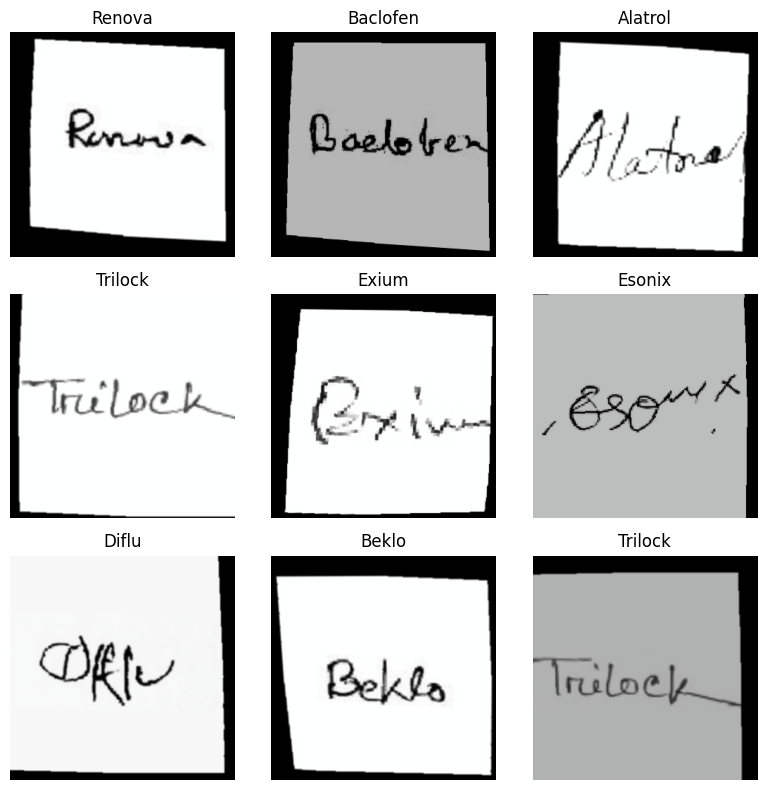

Train class distribution:


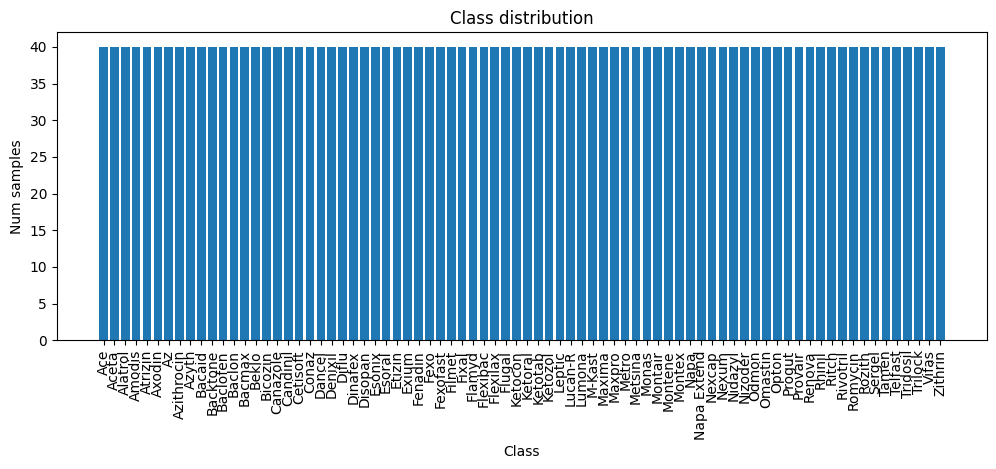

Validation class distribution:


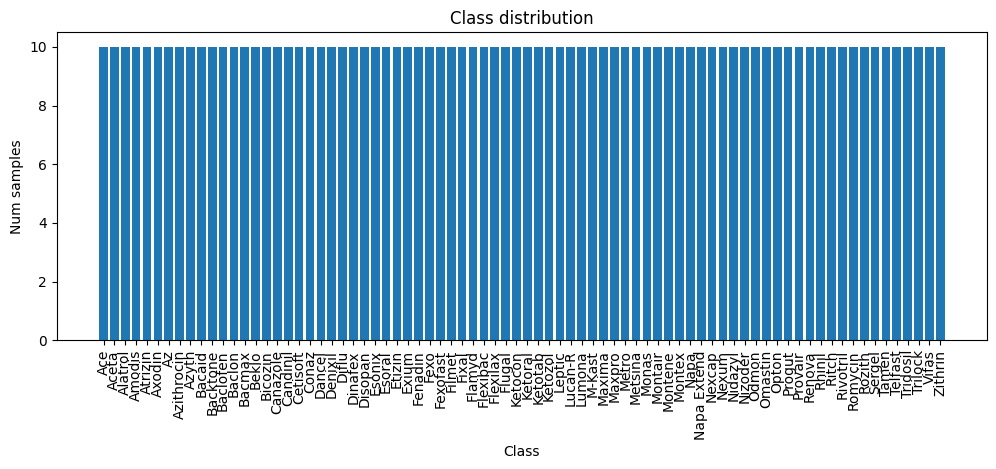

In [32]:
import matplotlib.pyplot as plt
import random

def show_sample_images(dataset, num_samples=9):
    dataset_indices = list(range(len(dataset)))
    sample_indices = random.sample(dataset_indices, min(num_samples, len(dataset)))
    
    plt.figure(figsize=(8,8))
    for i, idx in enumerate(sample_indices, 1):
        img, label = dataset[idx]
        img_np = img.permute(1,2,0).numpy()  # CHW -> HWC
        img_np = (img_np * IMAGENET_STD + IMAGENET_MEAN)  # Denormalize
        img_np = np.clip(img_np, 0, 1)
        plt.subplot(3,3,i)
        plt.imshow(img_np)
        plt.title(dataset.classes[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def plot_class_distribution(dataset):
    import collections
    counter = collections.Counter(dataset.targets)
    counts = [counter[i] for i in range(len(dataset.classes))]
    
    plt.figure(figsize=(12,4))
    plt.bar(range(len(dataset.classes)), counts)
    plt.xticks(range(len(dataset.classes)), dataset.classes, rotation=90)
    plt.xlabel("Class")
    plt.ylabel("Num samples")
    plt.title("Class distribution")
    plt.show()

# -----------------------------
# Visualize some samples
# -----------------------------
print("Train samples preview:")
show_sample_images(train_ds, num_samples=9)

# -----------------------------
# Class distribution
# -----------------------------
print("Train class distribution:")
plot_class_distribution(train_ds)

print("Validation class distribution:")
plot_class_distribution(val_ds)


Device: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Linear(in_features=512, out_features=78, bias=True)
[Epoch 01/20] train_loss=3.1988 train_acc=0.2625 | val_loss=1.7083 val_acc=0.5551 | time=70.7s
  -> Improved. Saved to ./checkpoints_resnet18/best_resnet18.pt
[Epoch 02/20] train_loss=0.8479 train_acc=0.8439 | val_loss=1.0678 val_acc=0.7205 | time=69.2s
  -> Improved. Saved to ./checkpoints_resnet18/best_resnet18.pt
[Epoch 03/20] train_loss=0.3057 train_acc=0.9436 | val_loss=0.6236 val_acc=0.8513 | time=69.5s
  -> Improved. Saved to ./checkpoints_resnet18/best_resnet18.pt
[Epoch 04/20] train_loss=0.1875 train_acc=0.9660 | val_loss=0.4766 val_acc=0.8846 | time=69.5s
  -> Improved. Saved to ./checkpoints_resnet18/best_resnet18.pt
[Epoch 05/20] train_loss=0.1369 train_acc=0.9737 | val_loss=0.4119 val_acc=0.9026 | time=69.2s
  -> Improved. Saved to ./checkpoints_resnet18/best_resnet18.pt
[Epoch 06/20] train_loss=0.0905 train_acc=0.9862 | val_loss=0.3804 val_acc=0.9167 | time=69.3s
  -> Improved. Saved to ./checkpoints_resnet18/best_resnet

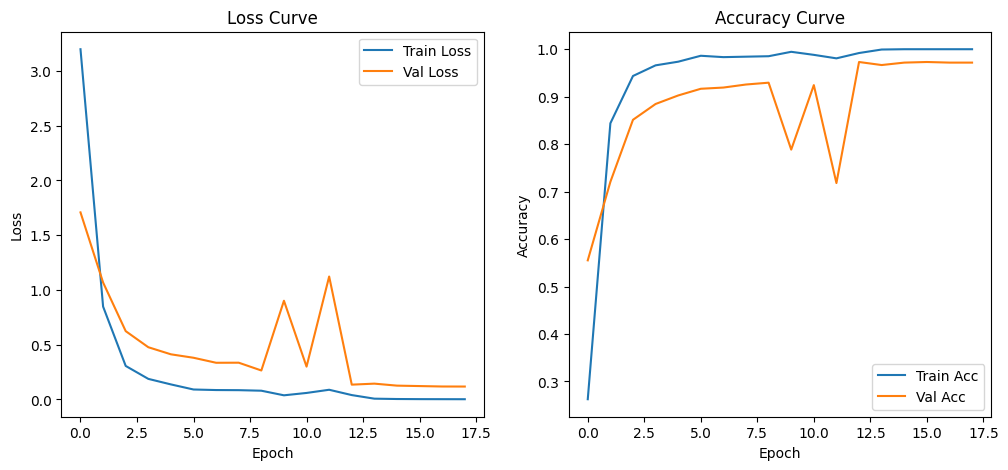

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import time

# -----------------------------
# Device
# -----------------------------
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

# -----------------------------
# Hyperparameters
# -----------------------------
LR = 1e-3
WEIGHT_DECAY = 1e-4
EPOCHS = 20
PATIENCE = 5
SAVE_DIR = "./checkpoints_resnet18"
os.makedirs(SAVE_DIR, exist_ok=True)
best_path = os.path.join(SAVE_DIR, "best_resnet18.pt")

# -----------------------------
# Model
# -----------------------------
from torchvision import models

# Use pretrained ImageNet weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Replace FC for num_classes
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)
model = model.to(DEVICE)

# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

print(model.fc)

# -----------------------------
# Training & Evaluation Functions
# -----------------------------
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        preds = logits.argmax(1)
        total_loss += loss.item() * imgs.size(0)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)

    return total_loss/total_samples, total_correct/total_samples

@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    all_preds, all_labels = [], []

    for imgs, labels in loader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        logits = model(imgs)
        loss = criterion(logits, labels)
        preds = logits.argmax(1)

        total_loss += loss.item() * imgs.size(0)
        total_correct += (preds == labels).sum().item()
        total_samples += imgs.size(0)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

    avg_loss = total_loss / total_samples
    avg_acc = total_correct / total_samples
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return avg_loss, avg_acc, all_preds, all_labels

# -----------------------------
# Training Loop with Early Stopping
# -----------------------------
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
best_val_acc = 0.0
epochs_no_improve = 0

for epoch in range(1, EPOCHS+1):
    t0 = time.time()
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    va_loss, va_acc, _, _ = evaluate(model, val_loader, criterion)
    scheduler.step(va_acc)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)

    print(f"[Epoch {epoch:02d}/{EPOCHS}] "
          f"train_loss={tr_loss:.4f} train_acc={tr_acc:.4f} | "
          f"val_loss={va_loss:.4f} val_acc={va_acc:.4f} | "
          f"time={(time.time()-t0):.1f}s")

    # Save checkpoint if improved
    if va_acc > best_val_acc:
        best_val_acc = va_acc
        epochs_no_improve = 0
        torch.save({
            "epoch": epoch,
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "val_acc": va_acc,
            "label_map": list(le.classes_)
        }, best_path)
        print(f"  -> Improved. Saved to {best_path}")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping after {PATIENCE} epochs without improvement.")
            break

print("Best Validation Accuracy:", best_val_acc)

# -----------------------------
# Load Best Model & Test Evaluation
# -----------------------------
checkpoint = torch.load(best_path, map_location=DEVICE)
model.load_state_dict(checkpoint["state_dict"])
test_loss, test_acc, test_preds, test_labels = evaluate(model, test_loader, criterion)

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

# -----------------------------
# Plot Training Curves
# -----------------------------
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


 Loaded best model from epoch 13 with val_acc=0.9731

=== TEST METRICS ===
Test Loss : 0.3300
Test Acc  : 0.9526

Classification Report:
               precision    recall  f1-score   support

         Ace     1.0000    1.0000    1.0000        10
       Aceta     1.0000    1.0000    1.0000        10
     Alatrol     1.0000    1.0000    1.0000        10
      Amodis     1.0000    1.0000    1.0000        10
     Atrizin     1.0000    1.0000    1.0000        10
      Axodin     1.0000    1.0000    1.0000        10
          Az     1.0000    1.0000    1.0000        10
  Azithrocin     1.0000    1.0000    1.0000        10
       Azyth     1.0000    1.0000    1.0000        10
      Bacaid     0.9000    0.9000    0.9000        10
    Backtone     1.0000    1.0000    1.0000        10
    Baclofen     1.0000    1.0000    1.0000        10
      Baclon     1.0000    1.0000    1.0000        10
      Bacmax     1.0000    1.0000    1.0000        10
       Beklo     1.0000    0.9000    0.9474        

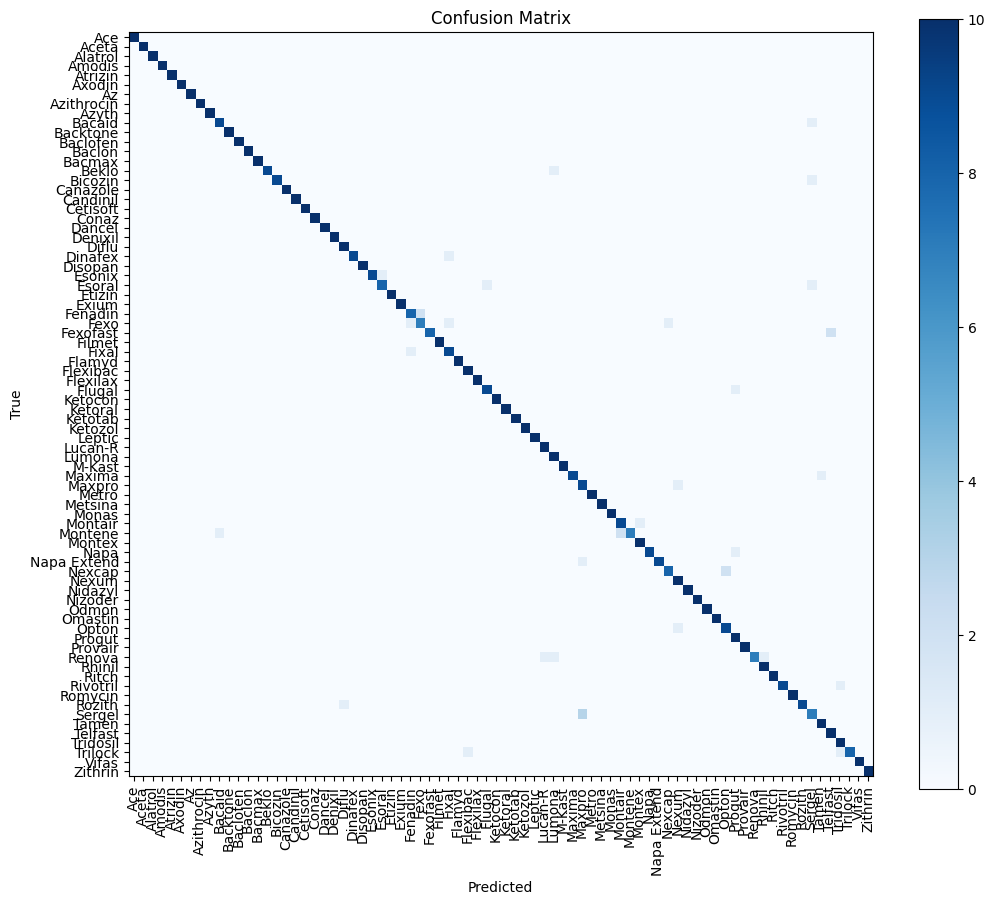

 Label map saved to: ./checkpoints_resnet18/label_map.json


In [42]:
if os.path.exists(best_path):
    ckpt = torch.load(best_path, map_location=DEVICE)
    model.load_state_dict(ckpt["state_dict"])
    print(f" Loaded best model from epoch {ckpt['epoch']} with val_acc={ckpt['val_acc']:.4f}")
else:
    print(" Best checkpoint not found, using current model weights.")

test_loss, test_acc, y_pred, y_true = evaluate(model, test_loader, criterion)

print("\n=== TEST METRICS ===")
print(f"Test Loss : {test_loss:.4f}")
print(f"Test Acc  : {test_acc:.4f}")

target_names = list(le.classes_)
report = classification_report(y_true, y_pred, target_names=target_names, digits=4)
print("\nClassification Report:\n", report)

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)

cm_csv = os.path.join(SAVE_DIR, "confusion_matrix_resnet18.csv")
cm_df.to_csv(cm_csv, encoding="utf-8-sig")
print(" Confusion matrix saved to:", cm_csv)

# Optional: visualize confusion matrix
plt.figure(figsize=(12,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks(range(len(target_names)), target_names, rotation=90)
plt.yticks(range(len(target_names)), target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

label_map_path = os.path.join(SAVE_DIR, "label_map.json")
with open(label_map_path, "w", encoding="utf-8") as f:
    json.dump({i: cls for i, cls in enumerate(target_names)}, f, ensure_ascii=False, indent=2)
print(" Label map saved to:", label_map_path)


In [45]:
import json
import pandas as pd
import os

dfs = []
for csv_path in [TRAIN_CSV, VAL_CSV, TEST_CSV]:
    if os.path.exists(csv_path):
        dfs.append(pd.read_csv(csv_path))
    else:
        print(f" CSV not found: {csv_path}")

df_combined = pd.concat(dfs, ignore_index=True)
print(f"Total rows combined: {len(df_combined)}")

df_combined = df_combined.dropna(subset=["MEDICINE_NAME", "GENERIC_NAME"])

# Resolve conflicts: pick the most frequent GENERIC_NAME per MEDICINE_NAME
df_resolved = (
    df_combined.groupby("MEDICINE_NAME")["GENERIC_NAME"]
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

med2gen_map = dict(zip(
    df_resolved["MEDICINE_NAME"].astype(str),
    df_resolved["GENERIC_NAME"].astype(str)
))
print(f" Final mapping created: {len(med2gen_map)} entries")

mapping_path = os.path.join(SAVE_DIR, "medicine_to_generic.json")
with open(mapping_path, "w", encoding="utf-8") as f:
    json.dump(med2gen_map, f, ensure_ascii=False, indent=2)

print(f" Medicine → Generic mapping saved to: {mapping_path}")


Total rows combined: 4680
 Final mapping created: 78 entries
 Medicine → Generic mapping saved to: ./checkpoints_resnet18/medicine_to_generic.json


In [47]:

# Load mapping JSON if not already in memory
mapping_path = os.path.join(SAVE_DIR, "medicine_to_generic.json")
with open(mapping_path, "r", encoding="utf-8") as f:
    med2gen_map = json.load(f)

# Convert predicted indices to medicine names
y_pred_meds = [le.classes_[idx] for idx in y_pred]
y_true_meds = [le.classes_[idx] for idx in y_true]

# Map medicine names to generic names
y_pred_generic = [med2gen_map.get(med, "UNKNOWN") for med in y_pred_meds]
y_true_generic = [med2gen_map.get(med, "UNKNOWN") for med in y_true_meds]

# Optional: Create a DataFrame to inspect predictions
df_results = pd.DataFrame({
    "True_Medicine": y_true_meds,
    "Pred_Medicine": y_pred_meds,
    "True_Generic": y_true_generic,
    "Pred_Generic": y_pred_generic
})

# Save predictions with generics
results_csv = os.path.join(SAVE_DIR, "test_predictions_with_generics.csv")
df_results.to_csv(results_csv, index=False, encoding="utf-8-sig")
print(f" Predictions with generics saved to: {results_csv}")

# Optional: Quick accuracy on generic level
generic_acc = np.mean(np.array(y_true_generic) == np.array(y_pred_generic))
print(f"Generic-level Accuracy: {generic_acc:.4f}")


 Predictions with generics saved to: ./checkpoints_resnet18/test_predictions_with_generics.csv
Generic-level Accuracy: 0.9782


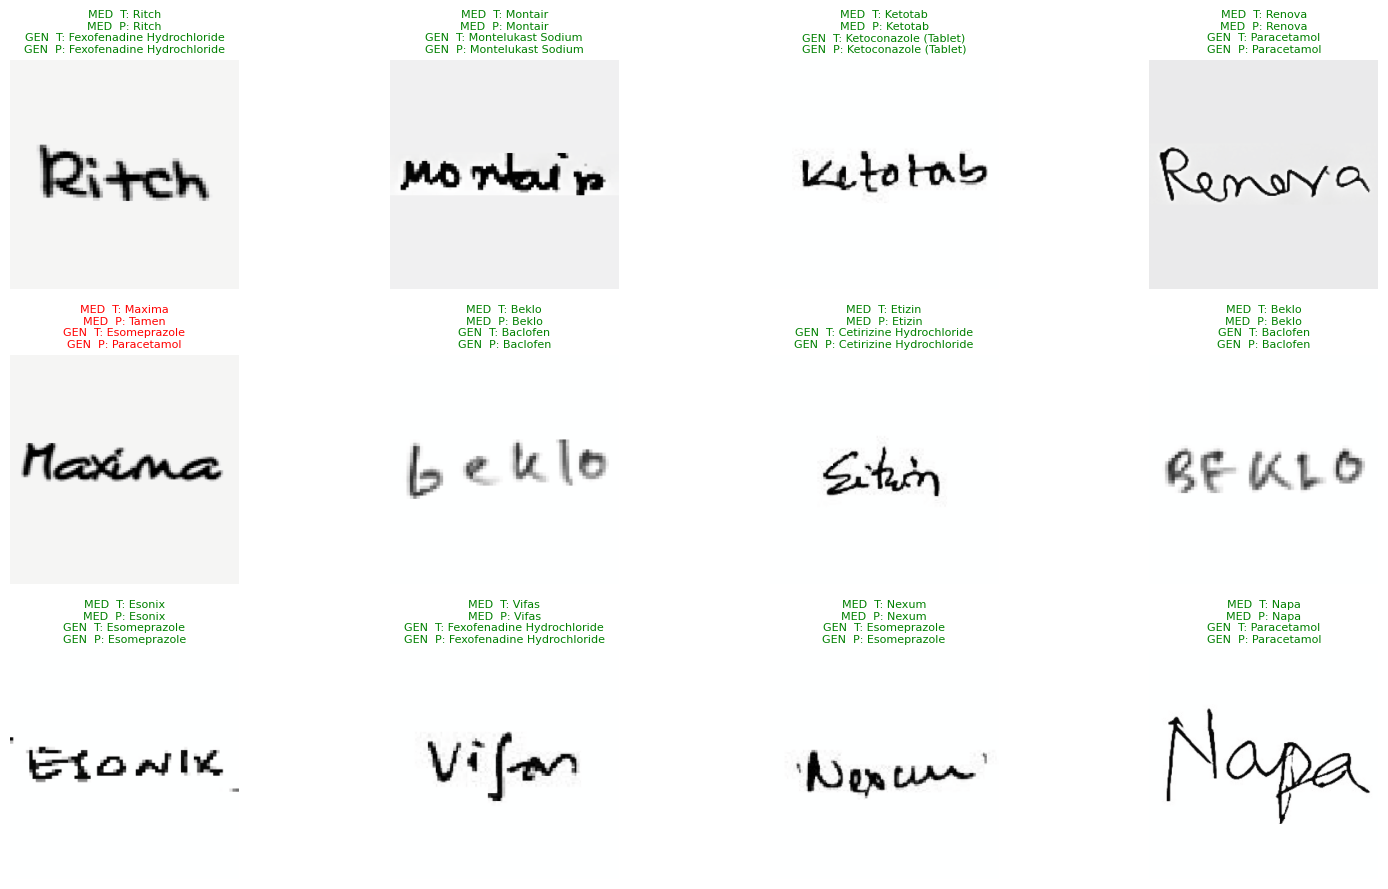

In [51]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch


def _undo_norm_to_rgb(img_tensor, mean=IMAGENET_MEAN, std=IMAGENET_STD):
    """
    Convert normalized tensor back to RGB image for plotting.
    """
    img_np = img_tensor.permute(1, 2, 0).cpu().numpy()
    img_np = img_np * np.array(std) + np.array(mean)
    img_np = np.clip(img_np, 0, 1)
    return img_np


def show_random_predictions_with_generic_map(
    model, dataset, le, med2gen_map, num_images=12
):
    model.eval()
    idxs = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(16, 9))
    for i, idx in enumerate(idxs):
        img, y_med = dataset[idx]
        img_input = img.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(img_input)
            pred_idx = out.argmax(1).item()

        # Convert tensor back to RGB for plotting
        img_np = _undo_norm_to_rgb(img)

        # Get labels
        true_med_str = le.classes_[y_med]
        pred_med_str = le.classes_[pred_idx]

        true_gen_str = med2gen_map.get(true_med_str, "?")
        pred_gen_str = med2gen_map.get(pred_med_str, "<NA>")

        # Green if correct medicine prediction, else red
        color = "green" if true_med_str == pred_med_str else "red"

        title_lines = [
            f"MED  T: {true_med_str}",
            f"MED  P: {pred_med_str}",
            f"GEN  T: {true_gen_str}",
            f"GEN  P: {pred_gen_str}",
        ]

        plt.subplot(int(np.ceil(num_images/4)), 4, i+1)
        plt.imshow(img_np)
        plt.title("\n".join(title_lines), color=color, fontsize=8)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


def show_random_predictions_medicine_only(model, dataset, le, num_images=12):
    model.eval()
    idxs = random.sample(range(len(dataset)), num_images)

    plt.figure(figsize=(16, 9))
    for i, idx in enumerate(idxs):
        img, y_med = dataset[idx]
        img_input = img.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(img_input)
            pred_idx = out.argmax(1).item()

        img_np = _undo_norm_to_rgb(img)

        true_med_str = le.classes_[y_med]
        pred_med_str = le.classes_[pred_idx]

        color = "green" if true_med_str == pred_med_str else "red"

        plt.subplot(int(np.ceil(num_images/4)), 4, i+1)
        plt.imshow(img_np)
        plt.title(f"T: {true_med_str}\nP: {pred_med_str}", color=color, fontsize=9)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


show_random_predictions_with_generic_map(
    model, test_ds, le, med2gen_map, num_images=12
)

# Optional: only medicine predictions
# show_random_predictions_medicine_only(model, test_ds, le, num_images=12)


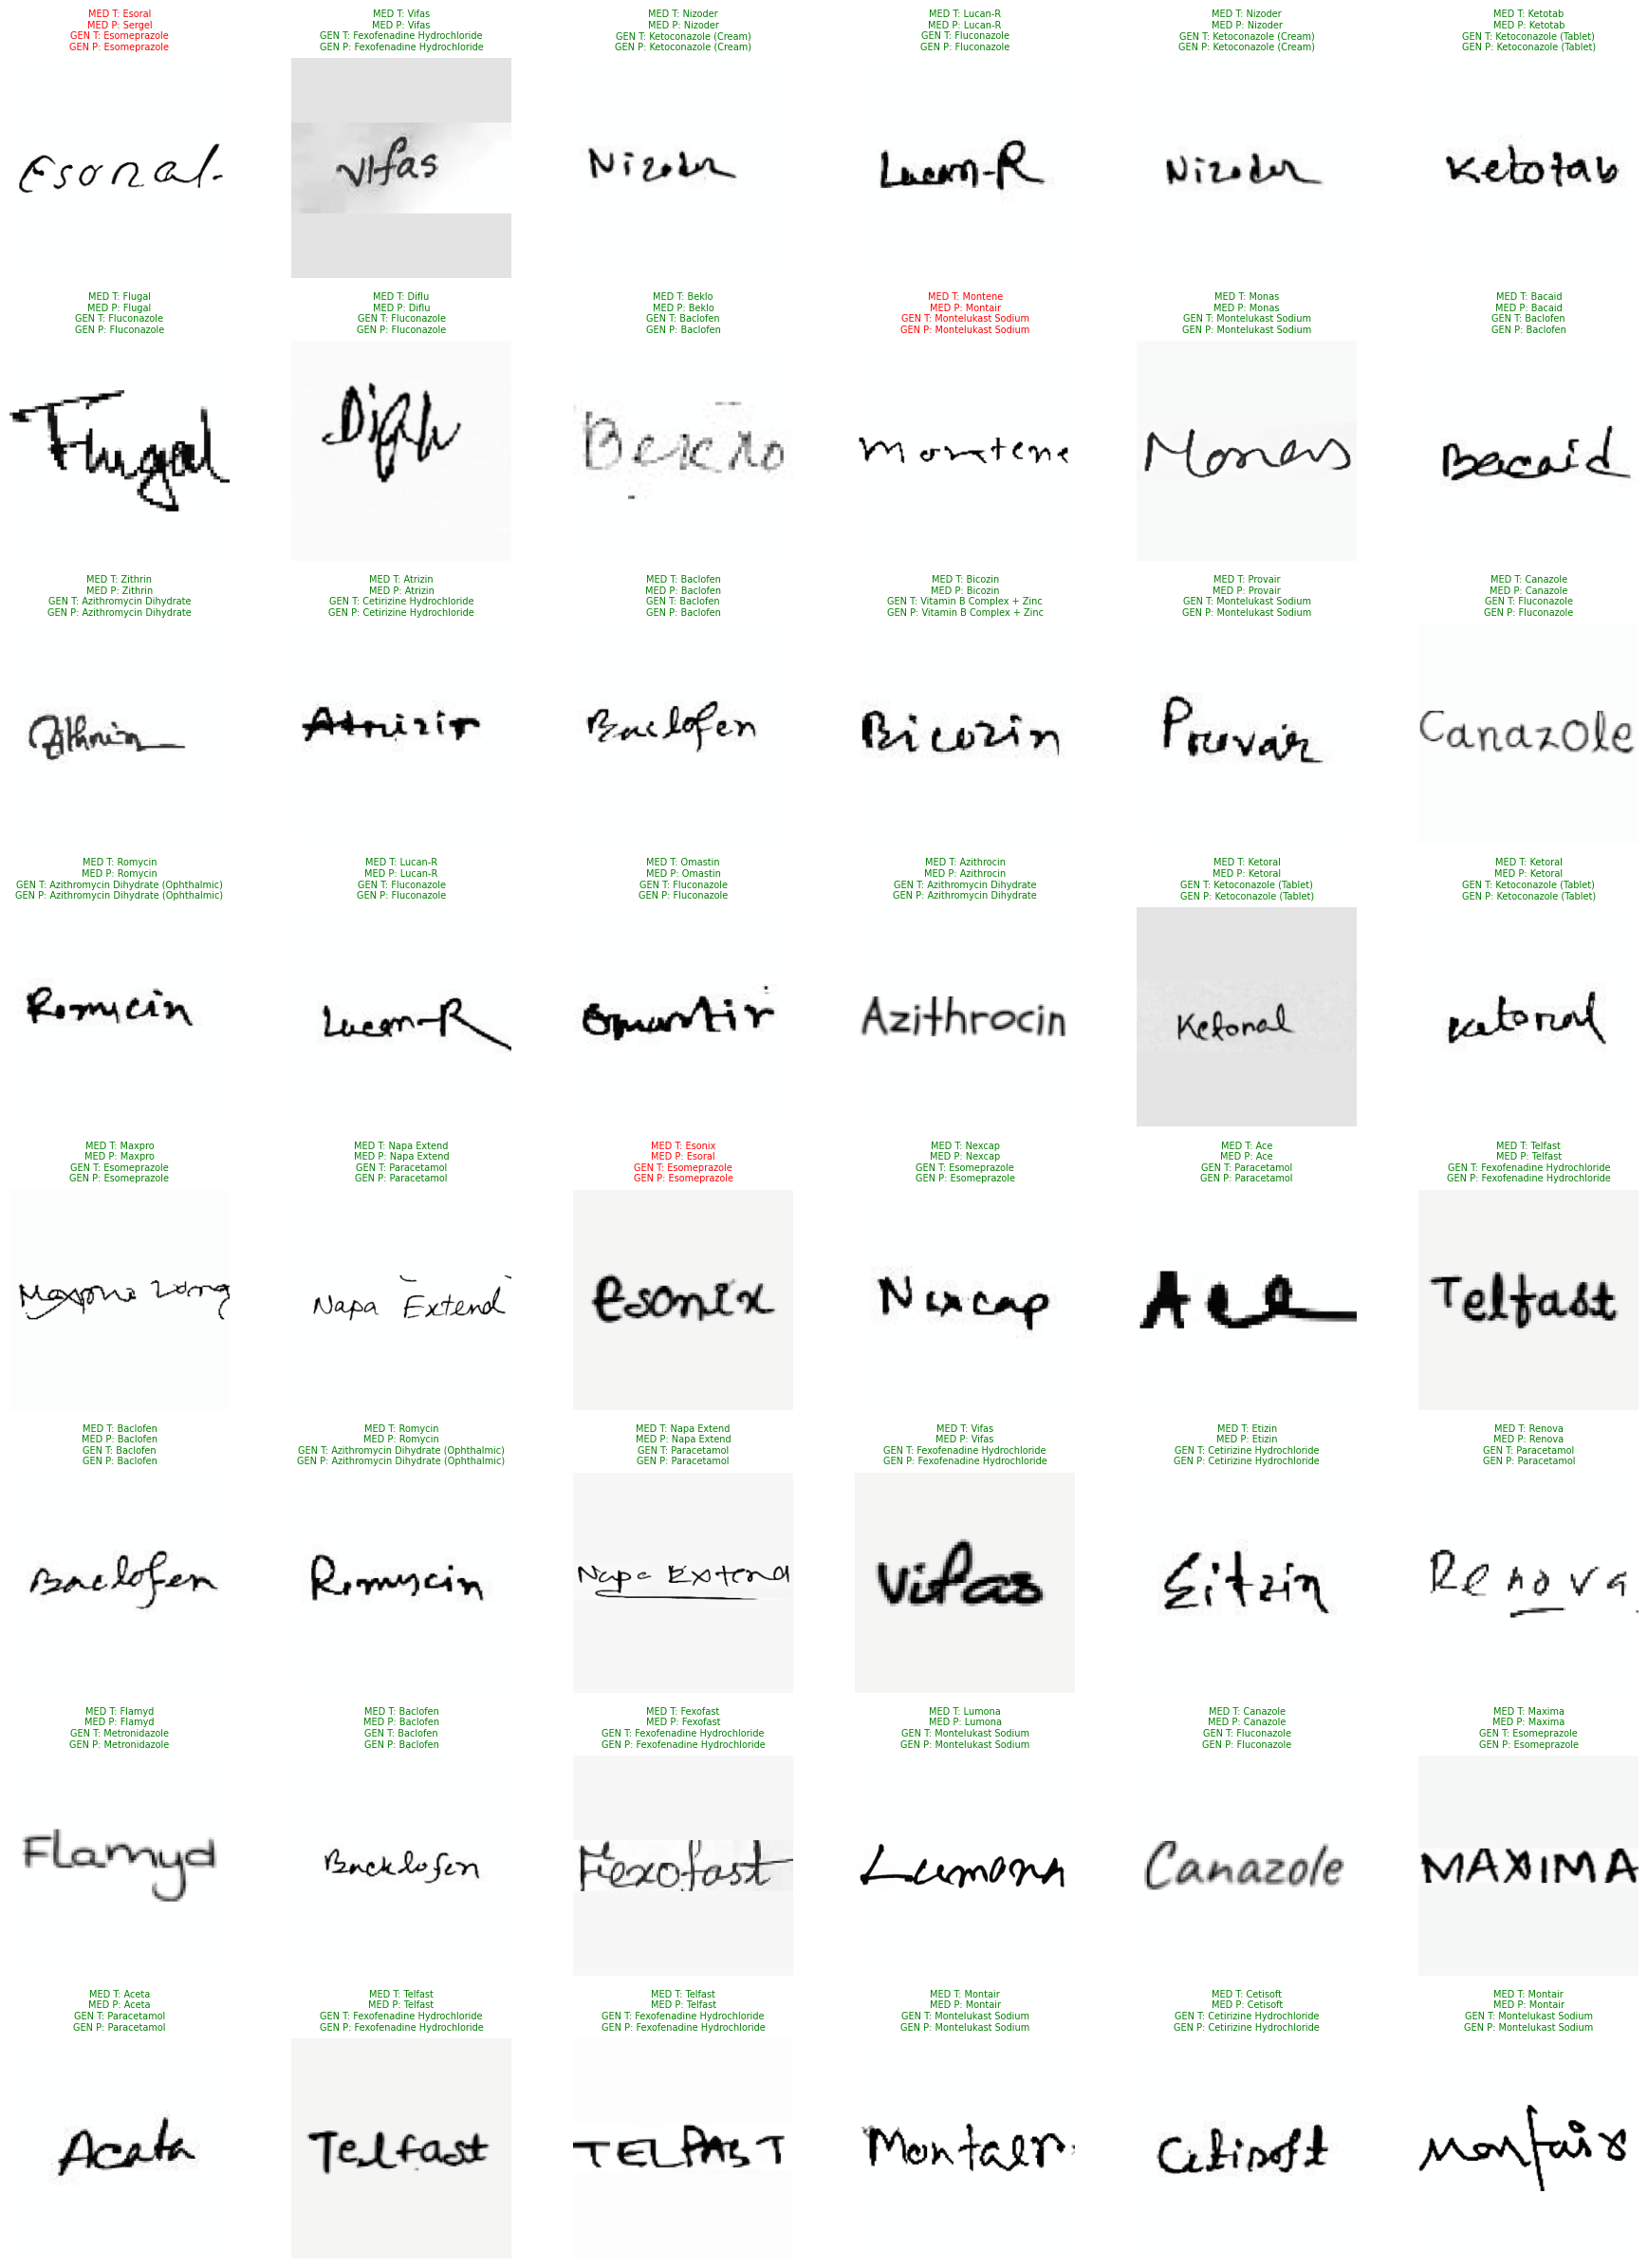

In [52]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
from IPython.display import display, HTML

def show_large_predictions_grid(
    model, dataset, le, med2gen_map, num_images=48, cols=6
):
    """
    Display a grid of random predictions with medicine and generic names.
    Works well for larger numbers of images.
    """
    model.eval()
    idxs = random.sample(range(len(dataset)), num_images)
    rows = int(np.ceil(num_images / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()

    for ax, idx in zip(axes, idxs):
        img, y_med = dataset[idx]
        img_input = img.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(img_input)
            pred_idx = out.argmax(1).item()

        # Undo normalization for plotting
        img_np = _undo_norm_to_rgb(img)

        # Labels
        true_med_str = le.classes_[y_med]
        pred_med_str = le.classes_[pred_idx]

        true_gen_str = med2gen_map.get(true_med_str, "?")
        pred_gen_str = med2gen_map.get(pred_med_str, "<NA>")

        # Color coding
        color = "green" if true_med_str == pred_med_str else "red"

        ax.imshow(img_np)
        ax.set_title(f"MED T: {true_med_str}\nMED P: {pred_med_str}\nGEN T: {true_gen_str}\nGEN P: {pred_gen_str}",
                     fontsize=7, color=color)
        ax.axis("off")

    # Remove extra axes if num_images < total subplots
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_large_predictions_grid(
    model, test_ds, le, med2gen_map, num_images=48, cols=6
)


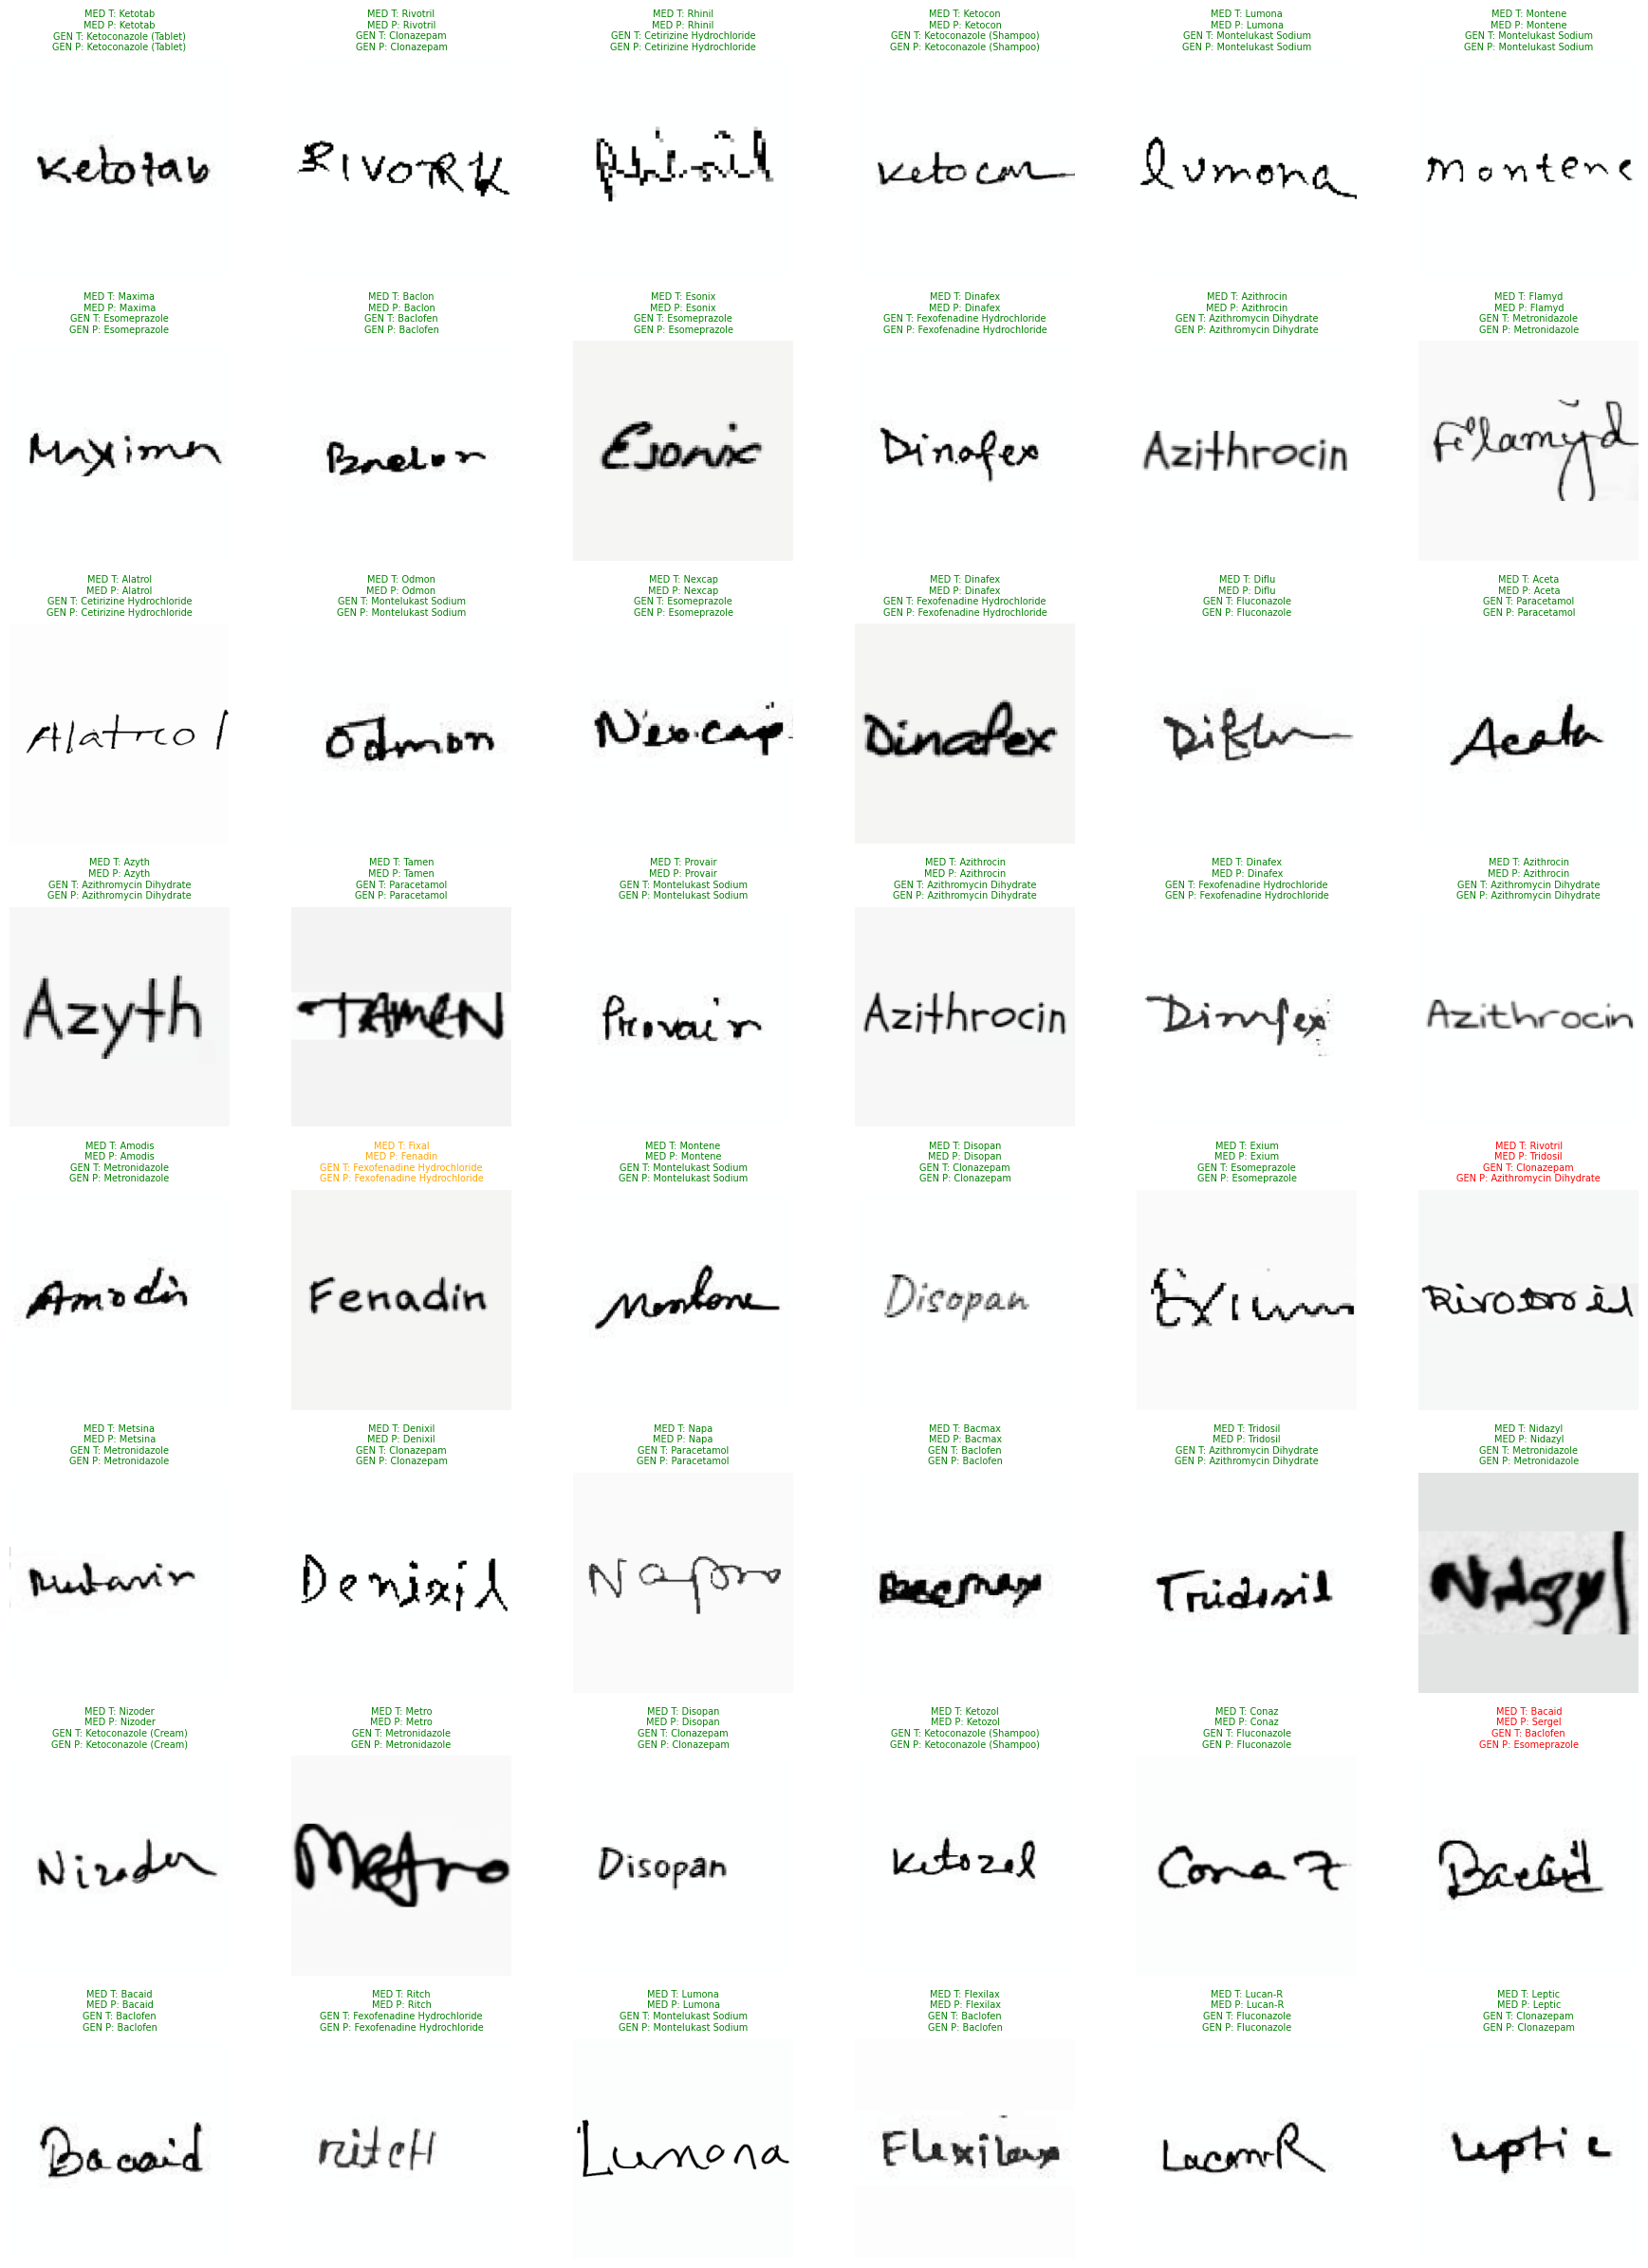

In [54]:
import matplotlib.pyplot as plt
import random
import numpy as np
import torch

def show_generic_correct_grid(
    model, dataset, le, med2gen_map, num_images=48, cols=6
):
    
    model.eval()
    idxs = random.sample(range(len(dataset)), num_images)
    rows = int(np.ceil(num_images / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axes = axes.flatten()

    for ax, idx in zip(axes, idxs):
        img, y_med = dataset[idx]
        img_input = img.unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            out = model(img_input)
            pred_idx = out.argmax(1).item()

        # Undo normalization for plotting
        img_np = _undo_norm_to_rgb(img)

        # Labels
        true_med_str = le.classes_[y_med]
        pred_med_str = le.classes_[pred_idx]

        true_gen_str = med2gen_map.get(true_med_str, "?")
        pred_gen_str = med2gen_map.get(pred_med_str, "<NA>")

        # Color coding
        if true_med_str == pred_med_str:
            color = "green"       # exact match
        elif true_gen_str == pred_gen_str:
            color = "orange"      # generic correct
        else:
            color = "red"         # wrong generic

        ax.imshow(img_np)
        ax.set_title(
            f"MED T: {true_med_str}\nMED P: {pred_med_str}\nGEN T: {true_gen_str}\nGEN P: {pred_gen_str}",
            fontsize=7, color=color
        )
        ax.axis("off")

    # Remove extra axes if num_images < total subplots
    for ax in axes[num_images:]:
        ax.axis("off")

    plt.tight_layout()
    plt.show()



show_generic_correct_grid(
    model, test_ds, le, med2gen_map, num_images=48, cols=6
)


In [61]:
import os
import json
from shutil import copyfile

SAVE_DIR = "./checkpoints_resnet18"
DOWNLOAD_DIR = "/kaggle/working/model_files"
os.makedirs(DOWNLOAD_DIR, exist_ok=True)

med2gen_map_path = os.path.join(SAVE_DIR, "med2gen_map.json")
if not os.path.exists(med2gen_map_path):
    # Assuming you already have the dictionary med2gen_map in memory
    with open(os.path.join(SAVE_DIR, "med2gen_map.json"), "w", encoding="utf-8") as f:
        json.dump(med2gen_map, f, ensure_ascii=False, indent=2)
    print(" med2gen_map.json saved successfully!")

files_to_copy = [
    "best_resnet18.pt",
    "label_map.json",
    "med2gen_map.json"
]

for file_name in files_to_copy:
    src_path = os.path.join(SAVE_DIR, file_name)
    dst_path = os.path.join(DOWNLOAD_DIR, file_name)
    if os.path.exists(src_path):
        copyfile(src_path, dst_path)
        print(f" Copied: {file_name}")
    else:
        print(f" File not found: {file_name}")

print("\nAll files are ready in:", DOWNLOAD_DIR)


 Copied: best_resnet18.pt
 Copied: label_map.json
 Copied: med2gen_map.json

All files are ready in: /kaggle/working/model_files
